In [99]:
import pandas as pd
import polars as pl
import polars.selectors as cs
from catboost import Pool, CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tempfile
import os
import zipfile
import shap
import plotly.io as pio
import plotly as plotly

plotly.offline.init_notebook_mode()
pio.renderers.default = "vscode+notebook"

In [100]:
def read_dataset_export(file_name, src_folder=".",
                        tmp_folder=None,
                        lazy=False,
                        verbose=False):
    json_file = None
    error_reason = ""
    tmp_folder = tmp_folder if tmp_folder else tempfile.gettempdir()

    if file_name.endswith(".json"):
        error_reason = "Error reading JSON file"
        if os.path.exists(file_name):
            json_file = file_name
        elif os.path.exists(os.path.join(src_folder, file_name)):
            json_file = os.path.join(src_folder, file_name)
        if json_file and verbose:
            print(error_reason, json_file)
        if json_file:
            if lazy:
                multi_line_json = pl.scan_ndjson(json_file)
            else:
                multi_line_json = pl.read_ndjson(json_file)

    else:
        zip_file = file_name
        if file_name.endswith(".zip"):
            error_reason = "Error reading ZIP file"
            if os.path.exists(file_name):
                zip_file = file_name
            elif os.path.exists(os.path.join(src_folder, file_name)):
                zip_file = os.path.join(src_folder, file_name)
            if verbose:
                print(error_reason, zip_file)

            if os.path.exists(zip_file):
                error_reason = "Error extracting data.json"
                if verbose:
                    print(error_reason, zip_file)

                json_file = os.path.join(tmp_folder, "data.json")
                if os.path.exists(json_file):
                    os.remove(json_file)

                with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                    all_zip_entries = zip_ref.namelist()
                    json_file_in_zip = [s for s in all_zip_entries if "data.json" in s]
                    if verbose:
                        print("data.json in zip file:", json_file_in_zip, zip_file)

                    for file in json_file_in_zip:
                        zip_ref.extract(file, tmp_folder)
                        json_file = os.path.join(tmp_folder, file)

                if not os.path.exists(json_file):
                    raise Exception(f"Dataset zipfile {zip_file} does not have \"data.json\"")
                if lazy:
                    multi_line_json = pl.scan_ndjson(json_file, infer_schema_length=100000)
                else:
                    multi_line_json = pl.read_ndjson(json_file, infer_schema_length=100000)
                    os.remove(json_file)

    if json_file is None:
        raise Exception(f"Dataset export not found {error_reason}")
    return multi_line_json

## Read and Pre-process data

In [101]:
df = read_dataset_export( "Web_ClickThrough.zip", lazy=True, verbose=True)
df.describe()

Error reading ZIP file Web_ClickThrough.zip
Error extracting data.json Web_ClickThrough.zip
data.json in zip file: ['data.json'] Web_ClickThrough.zip


shape: (9, 81)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ pyModelEv ┆ Decision_ ┆ Customer_ ┆ … ┆ IH_Web_In ┆ Context_D ┆ Context_C ┆ Customer │
│ ---       ┆ idence    ┆ Interacti ┆ IsInArrea ┆   ┆ bound_Cli ┆ irection  ┆ hannel    ┆ _OwnedAc │
│ str       ┆ ---       ┆ onID      ┆ rs        ┆   ┆ cked_pxLa ┆ ---       ┆ ---       ┆ countTyp │
│           ┆ str       ┆ ---       ┆ ---       ┆   ┆ stO…      ┆ str       ┆ str       ┆ es       │
│           ┆           ┆ str       ┆ str       ┆   ┆ ---       ┆           ┆           ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ str       ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 32091     ┆ 32091     ┆ 32091     ┆ … ┆ 32091     ┆ 32091     ┆ 32091     ┆ 9513     │
│ null_coun ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 22578    │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ std       ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ min       ┆ 0.0       ┆ -30426564 ┆           ┆ … ┆ 0.0000055 ┆ Inbound   ┆ Web       ┆          │
│           ┆           ┆ 586002052 ┆           ┆   ┆ 208333333 ┆           ┆           ┆          │
│           ┆           ┆ 16        ┆           ┆   ┆ 33333     ┆           ┆           ┆          │
│ 25%       ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 50%       ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 75%       ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ max       ┆ 9996.0    ┆ -30426564 ┆           ┆ … ┆ 1.8533307 ┆ Inbound   ┆ Web       ┆ Loan,    │
│           ┆           ┆ 586003999 ┆           ┆   ┆ 87037037  ┆           ┆           ┆ Loan,    │
│           ┆           ┆ 42        ┆           ┆   ┆           ┆           ┆           ┆ Loan,    │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ Loan     │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [102]:
columns = df.collect_schema().names()
columns.sort()
columns

['Context_Channel',
 'Context_Direction',
 'Context_Group',
 'Context_Issue',
 'Context_Name',
 'Context_Treatment',
 'Customer_AnnualIncome',
 'Customer_BirthDate',
 'Customer_CLV',
 'Customer_CreditScore',
 'Customer_DebtToIncomeRatio',
 'Customer_HasBrokenPromise',
 'Customer_HasCriticalIllness',
 'Customer_IsActiveMilitaryService',
 'Customer_IsB2C',
 'Customer_IsBankruptcy',
 'Customer_IsCreditScoreStale',
 'Customer_IsCustomerActive',
 'Customer_IsFinanciallyVulnerable',
 'Customer_IsInActiveComplaint',
 'Customer_IsInArrears',
 'Customer_IsInCollections',
 'Customer_IsInDisasterArea',
 'Customer_IsInPrecollections',
 'Customer_IsIncarcerated',
 'Customer_IsProspect',
 'Customer_IsStudent',
 'Customer_LinkedIn',
 'Customer_MKTCLVValue',
 'Customer_NetWealth',
 'Customer_NumCreditCardAccount',
 'Customer_NumDepositAccount',
 'Customer_NumInvestmentAccount',
 'Customer_NumLoanAccount',
 'Customer_OrganizationID',
 'Customer_OrganizationName',
 'Customer_OwnedAccountTypes',
 'Custom

In [103]:
df = df.unique(subset=['Decision_InteractionID', 'Context_Treatment'], keep='last')

In [104]:
df = df.with_columns(
    pl.when(pl.col(pl.String).str.len_chars() == 0)
    .then(None)
    .otherwise(pl.col(pl.String))
    .name.keep()
    ).with_columns(
        cs.ends_with("_DaysSince", 
                     "_pyHistoricalOutcomeCount",
                     "DaysinCurrentStage")
                     .cast(pl.Float64).fill_null(0),
        pl.col(
            [
                "Customer_AnnualIncome",
                "Customer_CreditScore",
                "Customer_DebtToIncomeRatio",
                "Customer_NetWealth",
                "Customer_RelationshipLengthDays",
                "Customer_TotalAssets",
                "Customer_TotalLiabilities",
                "Customer_BirthDate"
            ]
            )
        .cast(pl.Float64)
        .fill_null(0),
        cs.starts_with("Customer_Num").cast(pl.Float64).fill_null(0),
        cs.starts_with("Context_").cast(pl.String),
        cs.starts_with("Customer_Is").replace_strict({"false":False, "true":True, "null":False, "False":False, "True":True}),
        cs.starts_with("Customer_Has").replace_strict({"false":False, "true":True, "null":False, "False":False, "True":True})
    ).with_columns(
        cs.starts_with("Customer_Is").fill_null(False).cast(pl.Boolean),
        cs.starts_with("Customer_Has").fill_null(False).cast(pl.Boolean)
    ).with_columns(
        pl.col(
            [
                "Customer_AnnualIncome",
                "Customer_CreditScore",
                "Customer_DebtToIncomeRatio",
                "Customer_NetWealth",
                "Customer_RelationshipLengthDays",
                "Customer_TotalAssets",
                "Customer_TotalLiabilities"
            ]
        ).cast(pl.Float64).fill_null(0),
    )

In [105]:
df = df.drop(["rulesetVersion", "id", "dataCenter", "negativeSampling", "positiveSampling", "rulesetName",
                "Decision_SubjectID", "Decision_OutcomeTime", "Decision_Rank", "Decision_InteractionID",
                "Decision_DecisionTime", "Decision_OutcomeWeight", "pyModelEvidence", "pyModelPerformance", 
                "pyModelPositives", "pyPropensity", "rulesetVersion"])


In [106]:
cat_features = list()
schema = df.collect_schema()

for cname in schema.names():
    ctype = schema[cname]
    if(not(cname.startswith("Decision_")) and pl.String.is_(ctype)):
        df = df.with_columns(pl.col(cname).fill_null('N/A'))
        cat_features.append(cname)
print(cat_features)

['IH_Retail_Inbound_Impression_pxLastGroupID', 'Customer_PrimaryState', 'Customer_ResidentialStatus', 'Customer_PrimaryMobilePhone', 'Context_Group', 'IH_Web_Inbound_Clicked_pxLastGroupID', 'Param_Journey', 'Context_Issue', 'Customer_MKTCLVValue', 'Customer_OrganizationName', 'Customer_CLV', 'Customer_PrimaryCountry', 'Context_Name', 'Param_JourneyStage', 'Param_LastJourneyStage', 'IH_Web_Inbound_Impression_pxLastGroupID', 'Customer_OwnershipStatus', 'Param_PriorStageInJourney', 'Context_Treatment', 'Customer_LinkedIn', 'Customer_Prefix', 'Customer_PrimaryCountryCode', 'Customer_PrimaryPostalCode', 'Customer_OrganizationID', 'Customer_PrimaryCity', 'Context_Direction', 'Context_Channel', 'Customer_OwnedAccountTypes']


In [107]:
text_processing_options = {
    "tokenizers": [{
        "tokenizer_id": "comma",
        "delimiter": ",",
        "lowercasing": "true"
    }],

    "dictionaries": [{
        "dictionary_id": "Word",
        "gram_order": "1"
    }],

    "feature_processing": {
        "default": [{
            "dictionaries_names": ["Word"],
            "feature_calcers": ["BoW"],
            "tokenizers_names": ["comma"]
        }]
    }
}
text_features = ['Customer_OwnedAccountTypes']


In [108]:
cat_features = list(set(cat_features) - set(text_features))

In [109]:
df = df.collect()
df.head()

shape: (5, 64)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Customer_ ┆ Customer_ ┆ IH_Retail ┆ Customer_ ┆ … ┆ IH_Web_In ┆ Context_D ┆ Context_C ┆ Customer │
│ IsInArrea ┆ IsProspec ┆ _Inbound_ ┆ IsActiveM ┆   ┆ bound_Cli ┆ irection  ┆ hannel    ┆ _OwnedAc │
│ rs        ┆ t         ┆ Impressio ┆ ilitarySe ┆   ┆ cked_pxLa ┆ ---       ┆ ---       ┆ countTyp │
│ ---       ┆ ---       ┆ n_p…      ┆ rvi…      ┆   ┆ stO…      ┆ str       ┆ str       ┆ es       │
│ bool      ┆ bool      ┆ ---       ┆ ---       ┆   ┆ ---       ┆           ┆           ┆ ---      │
│           ┆           ┆ str       ┆ bool      ┆   ┆ f64       ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ false     ┆ false     ┆ N/A       ┆ false     ┆ … ┆ 0.001257  ┆ Inbound   ┆ Web       ┆ N/A      │
│ false     ┆ false     ┆ N/A       ┆ false     ┆ … ┆ 0.005339  ┆ Inbound   ┆ Web       ┆ N/A      │
│ false     ┆ false     ┆ N/A       ┆ false     ┆ … ┆ 0.007697  ┆ Inbound   ┆ Web       ┆ N/A      │
│ false     ┆ false     ┆ N/A       ┆ false     ┆ … ┆ 0.008526  ┆ Inbound   ┆ Web       ┆ N/A      │
│ false     ┆ false     ┆ N/A       ┆ false     ┆ … ┆ 0.003019  ┆ Inbound   ┆ Web       ┆ N/A      │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

## Train Model

- Automatic handling of categorical features without manual encoding
- Built‑in text processing (those properties cannot be used by ADM currently)

XGB model is trained to understand which features perform well and which not, when compared to ootb NB ADM. Text processing can be used to enhance model performance (in this example one property contains CSV lists, which cannot be processed by ADM, but, if this analysis reveals them as powerful predictors, can be further encoded and added to ADM models as predictors).

In [110]:
dset = df.to_pandas()
y = dset['Decision_Outcome']
X = dset.drop(['Decision_Outcome'], axis=1)
seed = 127
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=test_size, random_state=seed)

In [111]:

params = {'loss_function': 'Logloss',  # objective function
          'eval_metric': 'AUC',  # metric
          'verbose': 50,  # output to stdout info about training process every 50 iterations
          'random_seed': seed,
          'cat_features': cat_features,
          'text_features': text_features,
          'text_processing': text_processing_options,
          'one_hot_max_size': 1023,
          'class_names': ['NoResponse', 'Clicked'],
          'iterations': 100,
          'learning_rate': 0.5,
          'depth': 8
          }


In [112]:
%%time
cbc_1 = CatBoostClassifier(**params)
cbc_1.fit(X=X_train, y=y_train,  # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=(X_val, y_val),  # data to validate on
          # True if we don't want to save trees created after iteration with the best validation score
          use_best_model=True,
          # True for visualization of the training process (it is not shown in a published kernel - try executing this code)
          plot=True
          )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8568634	best: 0.8568634 (0)	total: 8.22ms	remaining: 814ms
50:	test: 0.8808364	best: 0.8851585 (8)	total: 330ms	remaining: 317ms
99:	test: 0.8747479	best: 0.8851585 (8)	total: 619ms	remaining: 0us

bestTest = 0.8851585395
bestIteration = 8

Shrink model to first 9 iterations.
CPU times: user 2.78 s, sys: 697 ms, total: 3.48 s
Wall time: 713 ms


## Review Model Parameters

In [113]:
pool = Pool(X_test, y_test, cat_features=cat_features, text_features=text_features)
#pool = Pool(X_test, y_test, cat_features=cat_features)

In [114]:
cbc_1.get_all_params()


{'nan_mode': 'Min',
 'eval_metric': 'AUC',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 100,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 1023,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 1,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderTy

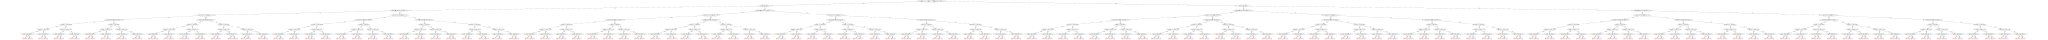

In [115]:
cbc_1.plot_tree(
    tree_idx=1,
    pool=pool
)


In [116]:
feature_importance = cbc_1.get_feature_importance(data=pool,
                                                  prettified=True,
                                                  verbose=True, type="PredictionValuesChange")
feature_importance


Used dataset leave statistics for fstr calculation


Feature Id  Importances
0                                        Customer_CLV    36.866382
1                                Customer_CreditScore    19.152898
2                          Customer_DebtToIncomeRatio    17.961440
3                     Customer_RelationshipLengthDays     9.572969
4   IH_Web_Inbound_Impression_pxLastOutcomeTime_Da...     3.770789
..                                                ...          ...
58                            Customer_OrganizationID     0.000000
59                               Customer_PrimaryCity     0.000000
60                           Param_DaysinCurrentStage     0.000000
61                                  Context_Direction     0.000000
62                                    Context_Channel     0.000000

[63 rows x 2 columns]

In [117]:
feature_importance = cbc_1.get_feature_importance(data=pool,
                                                  prettified=True,
                                                  verbose=True, type="LossFunctionChange")
feature_importance


Used Logloss metric for fstr calculation
Selected 3210 documents from 3210 for LossFunctionChange calculation.
Used Logloss metric for fstr calculation
Started LossFunctionChange calculation
3210/3210 Process documents	passed time: 6.72ms	remaining time: 0us


Feature Id  Importances
0                          Customer_OwnedAccountTypes     0.147050
1                                Customer_CreditScore     0.060189
2                          Customer_DebtToIncomeRatio     0.054758
3                     Customer_RelationshipLengthDays     0.030252
4   IH_Web_Inbound_Clicked_pxLastOutcomeTime_DaysS...     0.005299
..                                                ...          ...
58  IH_Web_Inbound_Impression_pyHistoricalOutcomeC...    -0.000293
59                      Customer_NumCreditCardAccount    -0.000321
60                               Customer_TotalAssets    -0.000521
61                            Customer_NumLoanAccount    -0.000533
62                                 Customer_BirthDate    -0.000736

[63 rows x 2 columns]

In [118]:
# make the prediction using the resulting model
preds = cbc_1.predict(pool)
preds_proba = cbc_1.predict_proba(pool)
print(preds_proba[:5])
print(cbc_1.predict(pool, 'RawFormulaVal')[:5])


[[0.99580922 0.00419078]
 [0.96839389 0.03160611]
 [0.11126779 0.88873221]
 [0.61395444 0.38604556]
 [0.99759843 0.00240157]]
[-5.47066774 -3.42228835  2.07785618 -0.46396535 -6.02922831]


In [119]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, preds, labels=params.get('class_names')))
print(metrics.classification_report(
    y_test, preds, labels=params.get('class_names')))


[[ 945  292]
 [ 377 1596]]
              precision    recall  f1-score   support

  NoResponse       0.71      0.76      0.74      1237
     Clicked       0.85      0.81      0.83      1973

    accuracy                           0.79      3210
   macro avg       0.78      0.79      0.78      3210
weighted avg       0.80      0.79      0.79      3210



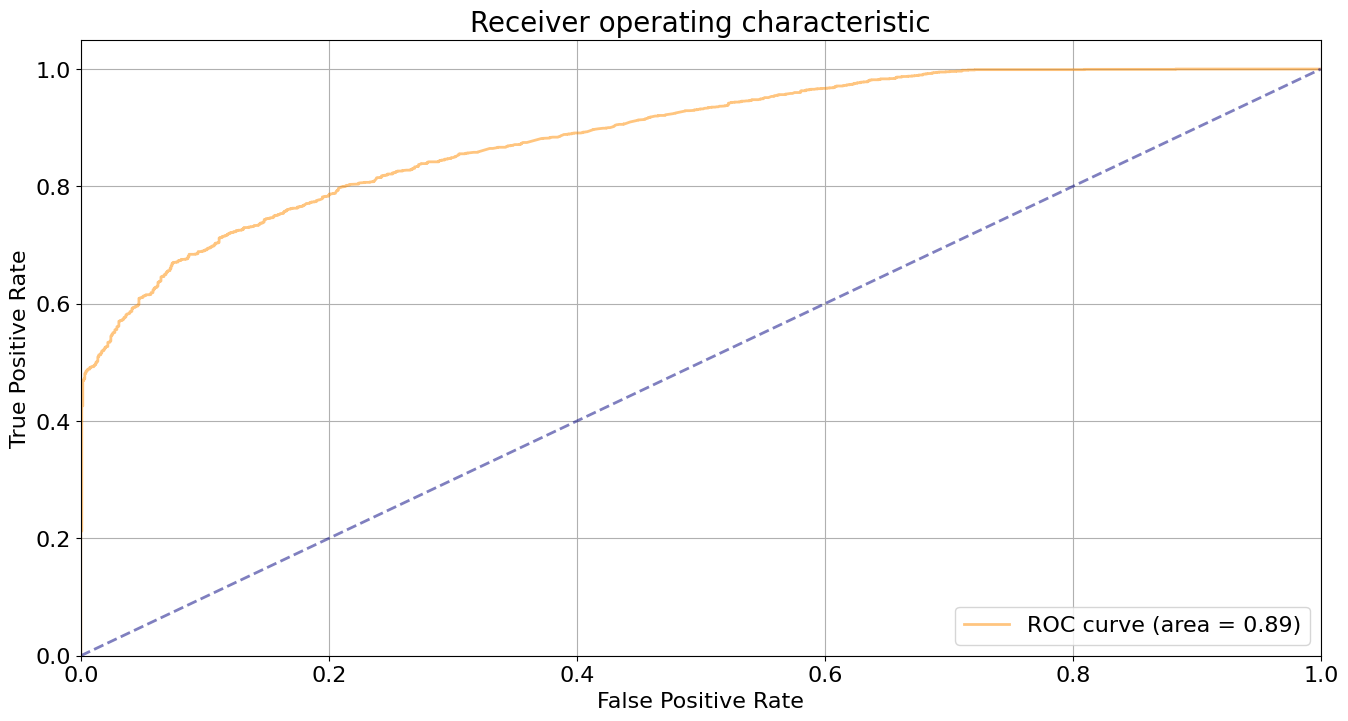

In [120]:
from catboost.utils import get_roc_curve
from sklearn.metrics import auc

curve = get_roc_curve(cbc_1, pool)
(fpr, tpr, thresholds) = curve
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [121]:
print('error:', 1-np.mean(preds == np.ravel(y_test)))


error: 0.20841121495327097


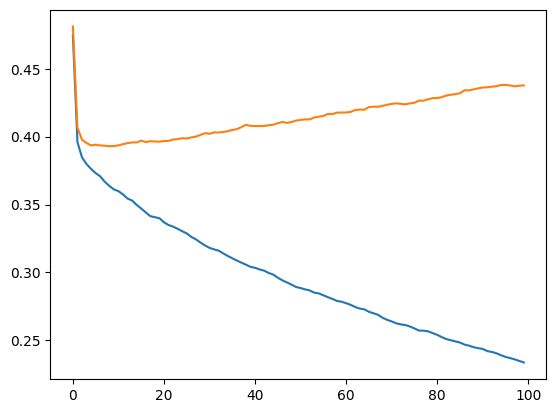

In [122]:
rmse_learn = pd.read_csv(
    'catboost_info/learn_error.tsv', header=0, delimiter='\t')
rmse_test = pd.read_csv('catboost_info/test_error.tsv',
                        header=0, delimiter='\t')
plt.plot(rmse_learn['Logloss'], label="Learn Error")
plt.plot(rmse_test['Logloss'], label="Test Error")


## Model Analysis

In [123]:
shap.initjs()

In [124]:
shap_values = cbc_1.get_feature_importance(pool, type="ShapValues")

In [125]:
expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]


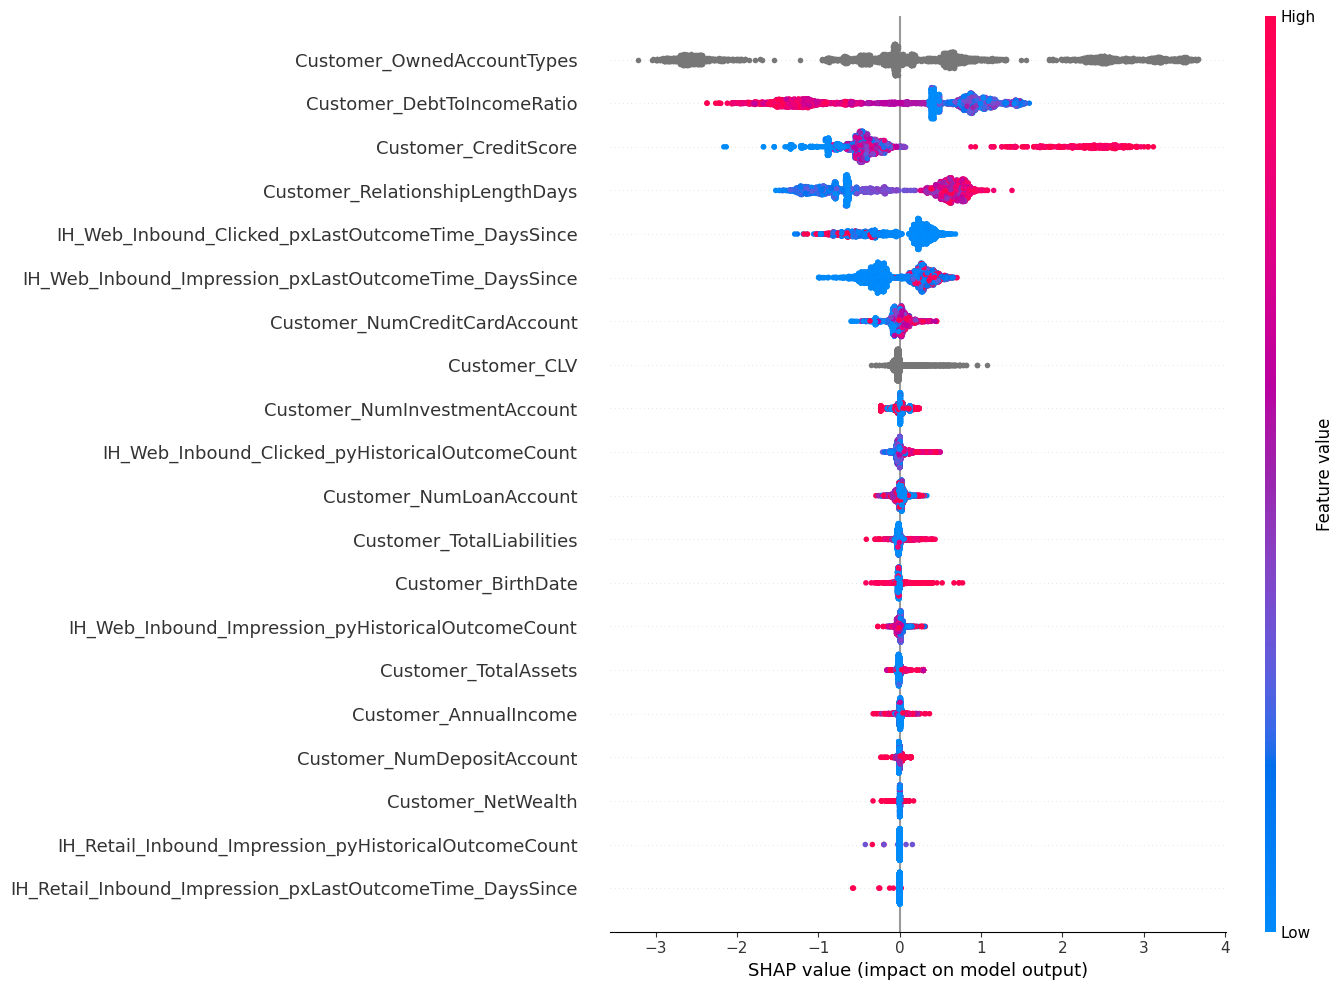

In [126]:
shap.summary_plot(shap_values, X_test, max_display=20, plot_size=[14,10])


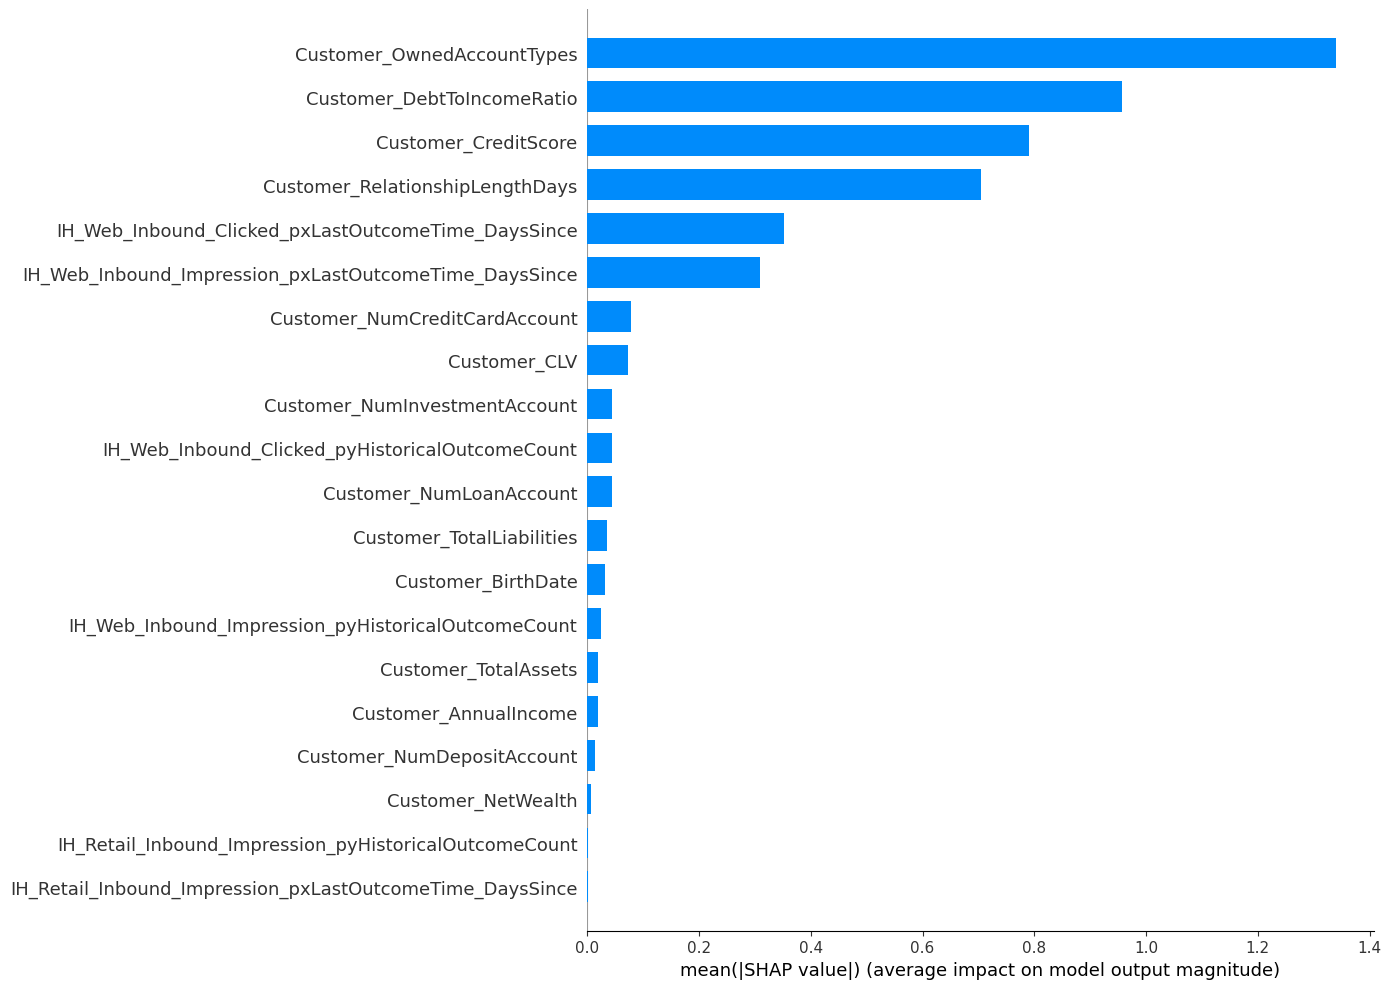

In [127]:
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=[14,10])

## Prediction Explanations

In [128]:

shap.plots.force(expected_value, shap_values[50], feature_names=X_test.columns)


## Individual Feature Analysis

In [129]:
feature = ['Customer_DebtToIncomeRatio', 'Customer_CreditScore', 'Customer_CLV', 'Customer_RelationshipLengthDays']
res = cbc_1.calc_feature_statistics(X_test, y_test, feature, plot=True)

### Analyse Model Without Text Features

In [130]:
dset = df.to_pandas()
y = dset['Decision_Outcome']
X = dset.drop(['Decision_Outcome'] + text_features, axis=1)
seed = 127
test_size = 0.2
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y, test_size=0.1, random_state=seed)
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_train2, y_train2, test_size=test_size, random_state=seed)

In [131]:
params = {'loss_function': 'Logloss',  # objective function
          'eval_metric': 'AUC',  # metric
          'verbose': 50,  # output to stdout info about training process every 50 iterations
          'random_seed': seed,
          'cat_features': cat_features,
          'class_names': ['NoResponse', 'Clicked'],
          'iterations': 100,
          'learning_rate': 0.5,
          'depth': 8
          }

In [132]:
%%time
cbc_2 = CatBoostClassifier(**params)
cbc_2.fit(X=X_train2, y=y_train2,  # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=(X_val2, y_val2),  # data to validate on
          # True if we don't want to save trees created after iteration with the best validation score
          use_best_model=True,
          # True for visualization of the training process (it is not shown in a published kernel - try executing this code)
          plot=True
          )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8241185	best: 0.8241185 (0)	total: 10.8ms	remaining: 1.06s
50:	test: 0.8816126	best: 0.8857634 (23)	total: 429ms	remaining: 412ms
99:	test: 0.8747540	best: 0.8857634 (23)	total: 821ms	remaining: 0us

bestTest = 0.8857633624
bestIteration = 23

Shrink model to first 24 iterations.
CPU times: user 4.69 s, sys: 831 ms, total: 5.52 s
Wall time: 935 ms


In [133]:
def print_score_diff(first_model, second_model):
    first_accuracy = first_model.best_score_['validation']['AUC']
    second_accuracy = second_model.best_score_['validation']['AUC']

    gap = (second_accuracy - first_accuracy) / first_accuracy * 100

    print('{} vs {} ({:+.2f}%)'.format(first_accuracy, second_accuracy, gap))
print('Model AUC difference - without text features vs with text features.')
print_score_diff(cbc_2, cbc_1)

Model AUC difference - without text features vs with text features.
0.8857633624228525 vs 0.8851585394538517 (-0.07%)


In [134]:
explainer = shap.TreeExplainer(cbc_2)
shap_values_exp = explainer(X_test2)

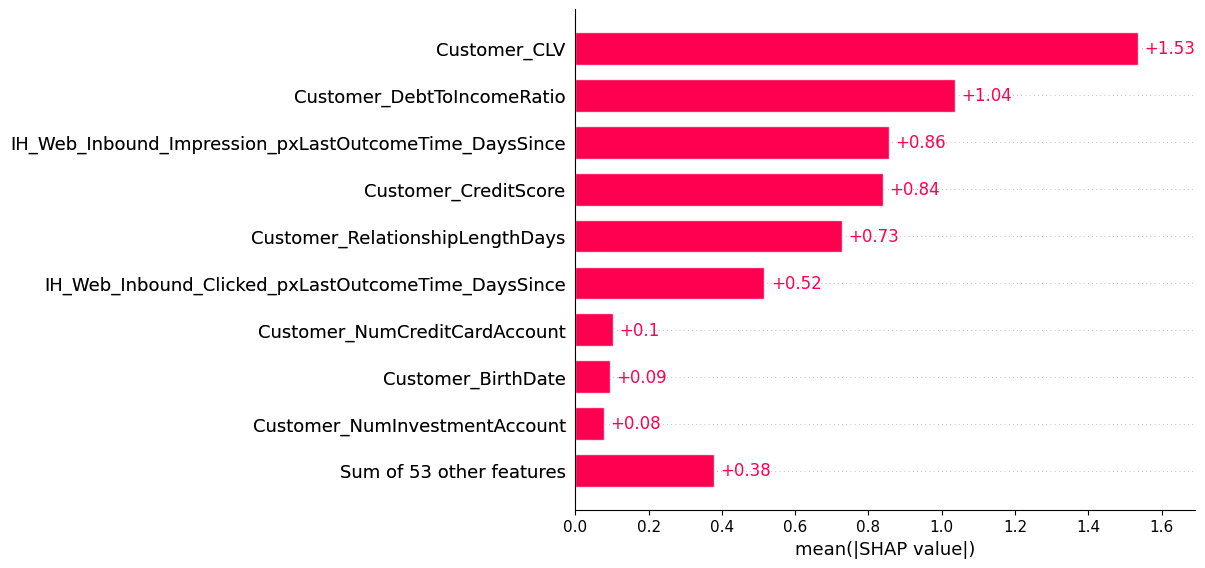

In [135]:
shap.plots.bar(shap_values_exp)

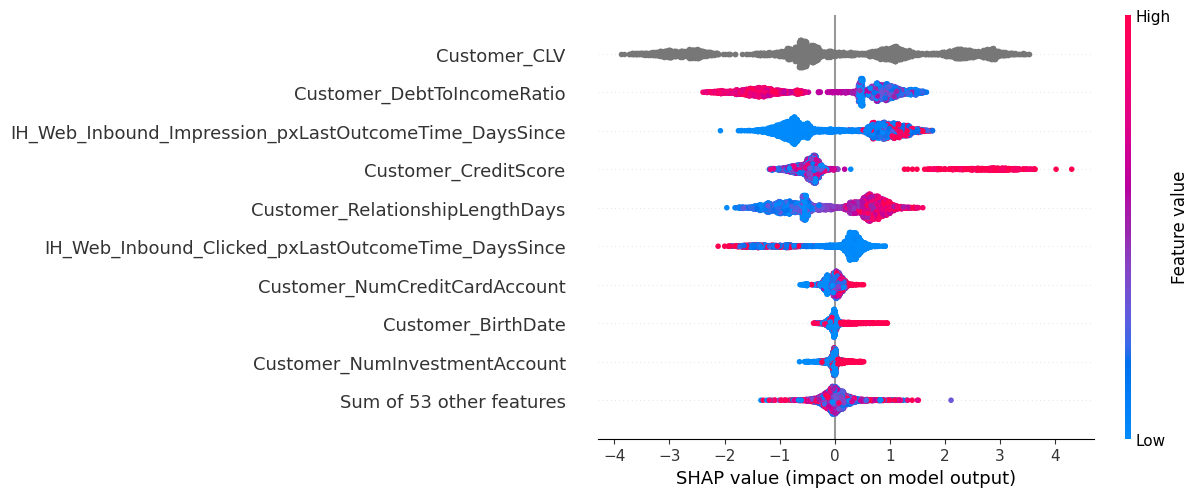

In [136]:
shap.plots.beeswarm(shap_values_exp)

In [137]:
shap.plots.force(explainer(X_test2.sample(n=500, random_state=seed)))

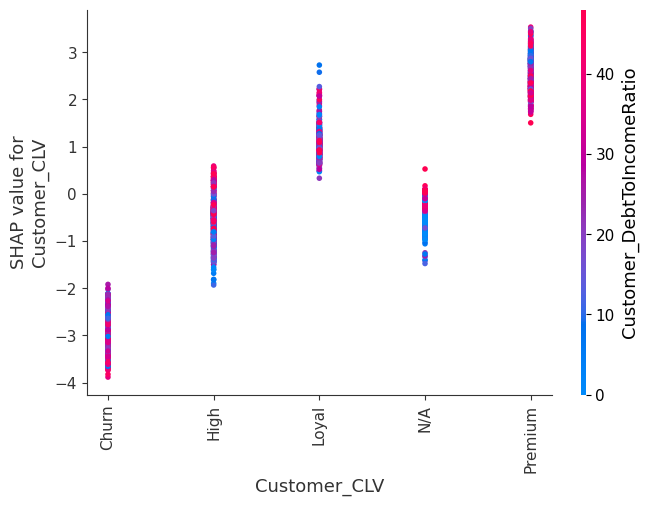

In [138]:
shap.dependence_plot("Customer_CLV", shap_values_exp.values, X_test2, interaction_index="Customer_DebtToIncomeRatio")

### Individual Predition Explanation

In [139]:
shap.plots.force(shap_values_exp[8])

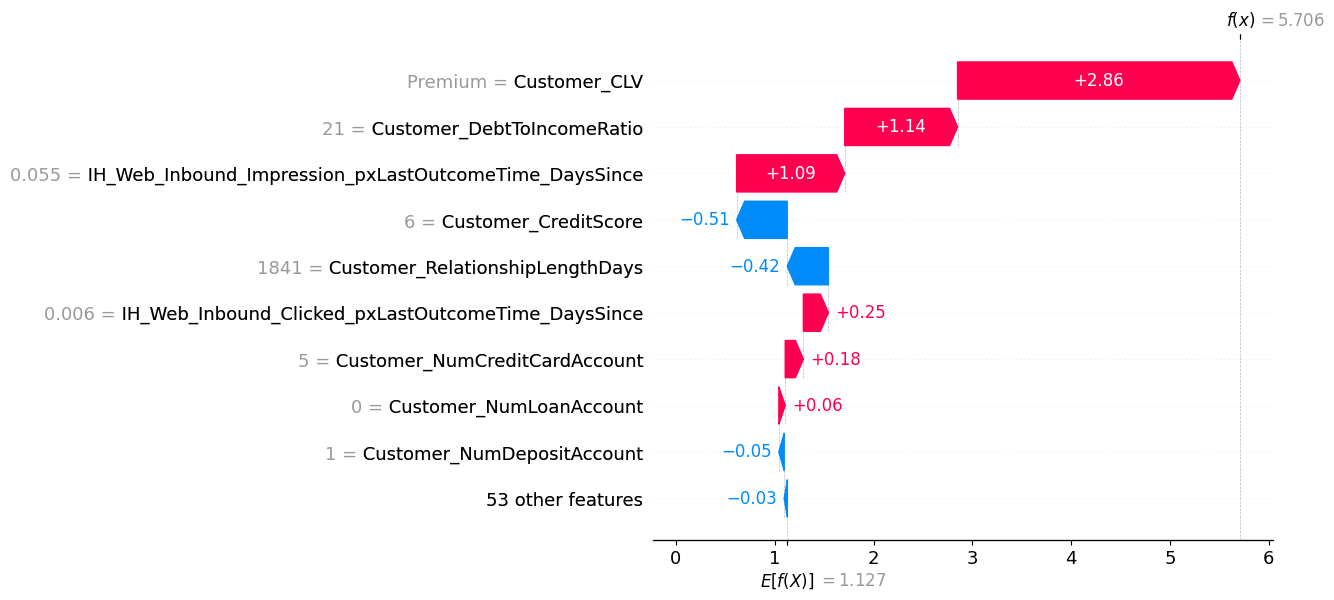

In [140]:
shap.plots.waterfall(shap_values_exp[8])

In [141]:
preds_proba = cbc_2.predict_proba(X_test2.iloc[8])
print(preds_proba)

[0.00331373 0.99668627]


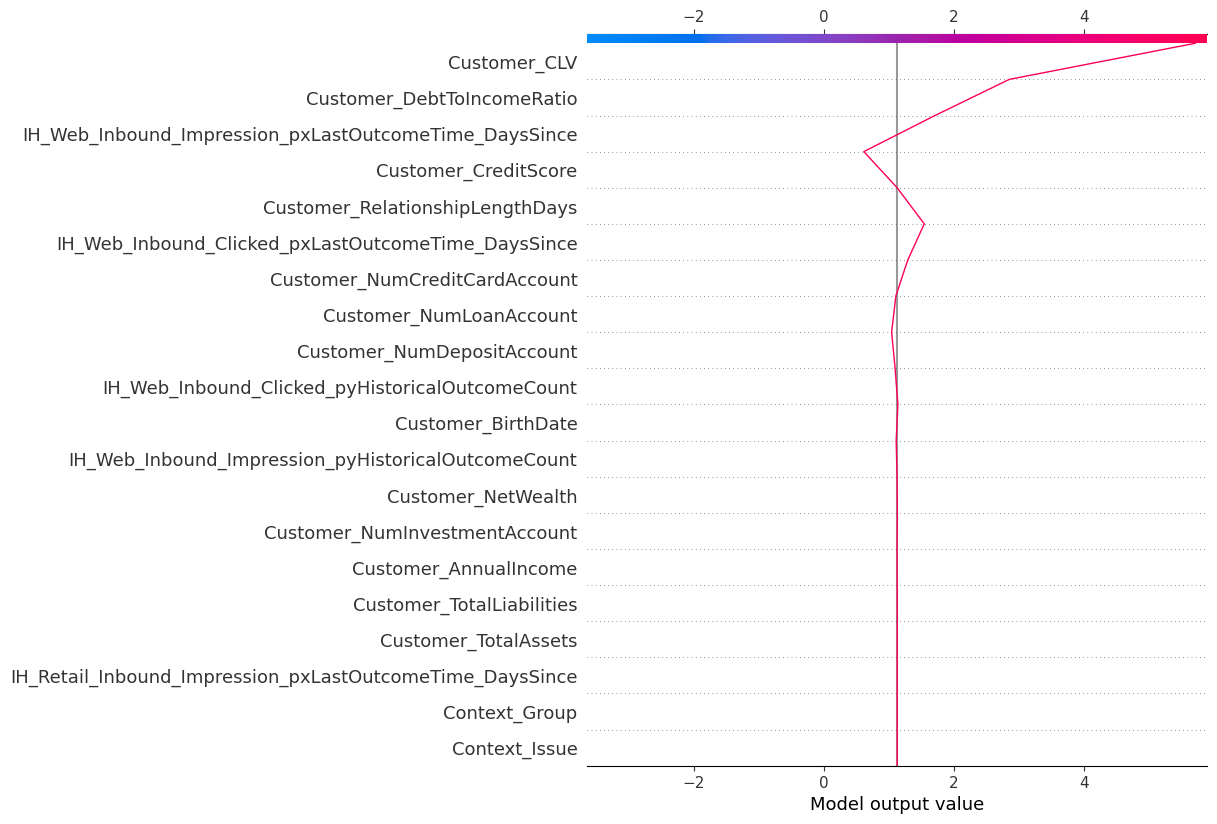

In [142]:
shap.decision_plot(
    base_value=np.array([explainer.expected_value]),
    shap_values=explainer.shap_values(X_test2)[8],
    features=X_test2.columns
)

### Feature dependency

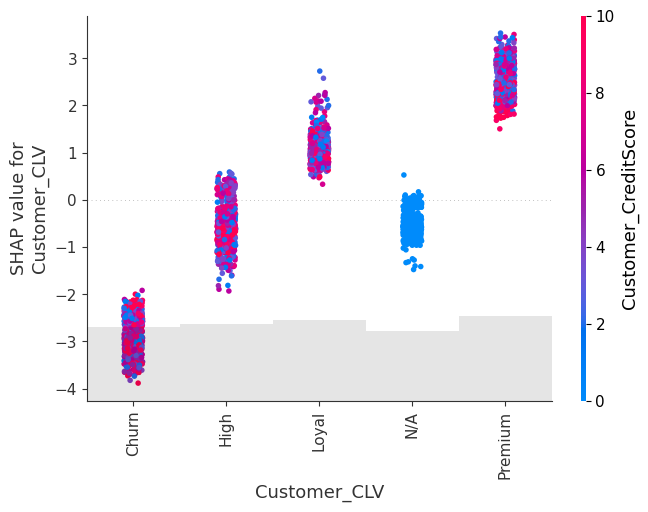

In [143]:
feature = 'Customer_CLV'
shap.plots.scatter(shap_values_exp[:, feature], color=shap_values_exp[:, "Customer_CreditScore"])

### Using global feature importance orderings

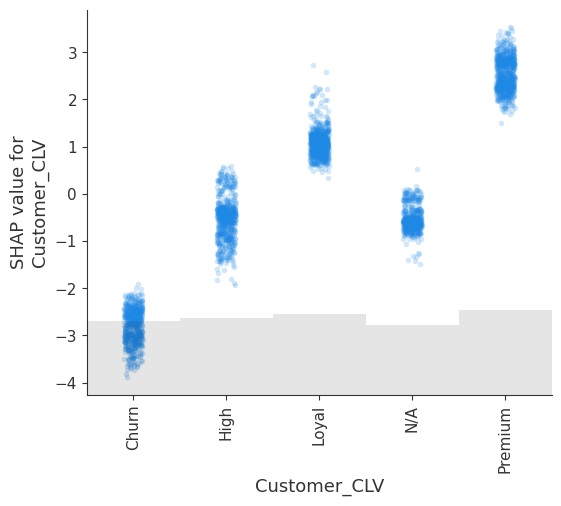

In [144]:
shap.plots.scatter(shap_values_exp[:, shap_values_exp.abs.mean(0).argsort[-1]], alpha=0.2)

## Model Calibration Quality

In [145]:
import numpy as np

# Calibration curves
def calibration(groundtruth, probs):
    # Convert groundtruth to binary and ensure probabilities are in a DataFrame
    groundtruth_binary = 1*np.array(groundtruth)
    nlabels = len(np.unique(groundtruth))
    
    if nlabels < 2:
        return pl.DataFrame({
            "MeanProbs": [0.5],
            "PositivesShare": [None],
            "binPos": [None],
            "binNeg": [None]
        })

    if nlabels > 2:
        raise ValueError("'groundtruth' has more than two levels.")
    
    # Create probabilities DataFrame with binning
    probabilities = pl.DataFrame({
        "groundtruth": groundtruth_binary,
        "probs": probs
    })

    # Group and summarize probabilities
    grouped_probabilities = (probabilities
                             .with_columns((pl.col("probs") * 10).round().alias("bin"))  # Binning probs to 1 decimal place
                             .group_by("bin")
                             .agg([
                                 pl.mean("probs").alias("MeanProbs"),
                                 pl.sum("groundtruth").alias("binPos"),
                                 (pl.count("groundtruth") - pl.sum("groundtruth")).alias("binNeg"),
                                 (pl.sum("groundtruth") / pl.count("groundtruth")).alias("PositivesShare")
                             ])
                             .sort("bin"))
    return grouped_probabilities

In [146]:
y_test_bin = y_test.apply(lambda x: x == 'Clicked')
preds_proba = cbc_1.predict_proba(X_test)
calibration_data = calibration(y_test_bin, preds_proba[:,1])

In [147]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.line(calibration_data, 
              x="MeanProbs", 
              y="PositivesShare")


# Add ideal calibration line (diagonal)
fig.add_shape(type="line", line=dict(dash='dash', color="darkred"), row='all', col='all', x0=0, y0=0, x1=1, y1=1)

# Customize the layout and labels
fig.update_layout(
    title="Model calibration plot",
    xaxis_title="Mean predicted probability",
    yaxis_title="Fraction of positives"
)

fig.show()